In [1]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os
import time

### Confirm Existence of .netrc file in your home directory

In [2]:
# make a .netrc file in your home directory with the following
# machine urs.earthdata.nasa.gov login ifenty password XCfK5QhgEGuWVgu4qRuH
# for login and password use your EarthData login

# if this command returns 1, you are good

In [3]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [4]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [5]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2022-04-20 16:43:29+00:00.



# Define important params

In [23]:
# output directory
output_dir=Path('/home/jovyan/Data/ECCO_GMSL/')
output_dir.mkdir(exist_ok=True)

# Prepare ECCO Daily SSH dataset

In [7]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

In [8]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

## Make a "direct connection" to the S3 file system

In [9]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [10]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

Note: this takes a minute.

In [11]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:38643")
# client

In [12]:
start_time = time.time()
ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*.nc'))
paths=[fs.open(f) for f in ECCO_SSH_files]

ECCO_DS_daily = xr.open_mfdataset(
paths=paths,
combine='nested',
concat_dim='time',
decode_cf=True,
coords='minimal',
chunks={'time': 1}  
)
ECCO_DS_daily.close()
print(time.time() - start_time)

In [24]:
ECCO_SSH = ECCO_DS_daily.SSH.mean(dim='time')
ECCO_SSH.name = 'mean_ssh'
ECCO_SSH.attrs['comment'] = 'mean ECCO SSH 1992-2017'
ECCO_SSH.attrs['source']='ECCO V4r4'

# Save to Disk
new_fname = 'ECCO_V4r4_mean_SSH.nc'
ECCO_SSH.to_netcdf(output_dir / new_fname)

In [21]:
ECCO_SSH

<xarray.DataArray 'mean_ssh' (latitude: 360, longitude: 720)>
dask.array<mean_agg-aggregate, shape=(360, 720), dtype=float32, chunksize=(360, 720), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    comment:  mean ECCO SSH 1992-2017
    source:   ECCO V4r4

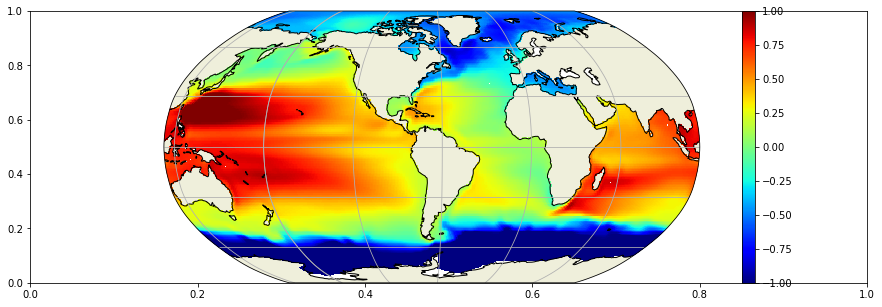

In [25]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(ECCO_SSH.longitude,\
                 ECCO_SSH.latitude, \
                 ECCO_SSH,\
                 transform=ccrs.PlateCarree(),
                 vmin=-1,vmax=1, cmap='jet')
h=plt.colorbar(p)